In [1]:
import numpy as np
import pandas as pd

# Data Import and Exploration

In [2]:
product_quality_log = pd.read_csv('task3_dataset/product_quality_log.csv')
product_quality_log = product_quality_log.drop(product_quality_log.columns[[0]], axis=1)
print(product_quality_log.head(7))

      machine_id product_id quality
0  Printer F0815   P3.2.500      OK
1  Printer F0815   P3.2.501      OK
2  Printer F0815   P3.2.502      OK
3  Printer F0815   P3.2.503      OK
4  Printer F0815   P3.2.504      OK
5  Printer F0815   P3.2.505      OK
6  Printer F0815   P3.2.506      OK


In [3]:
production_log = pd.read_csv('task3_dataset/production_log.csv')
production_log = production_log.drop(production_log.columns[[0]], axis=1)
print(production_log.head(7))

             timestamp product_id
0  2021-05-17_08-12-48   P3.2.500
1  2021-05-17_08-12-51   P3.2.501
2  2021-05-17_08-12-54   P3.2.502
3  2021-05-17_08-12-57   P3.2.503
4  2021-05-17_08-13-00   P3.2.504
5  2021-05-17_08-13-03   P3.2.505
6  2021-05-17_08-13-06   P3.2.506


In [4]:
complete_log = pd.merge(production_log, product_quality_log, on="product_id")
complete_log = complete_log.set_index('timestamp')
print(complete_log.head(7))

                    product_id     machine_id quality
timestamp                                            
2021-05-17_08-12-48   P3.2.500  Printer F0815      OK
2021-05-17_08-12-51   P3.2.501  Printer F0815      OK
2021-05-17_08-12-54   P3.2.502  Printer F0815      OK
2021-05-17_08-12-57   P3.2.503  Printer F0815      OK
2021-05-17_08-13-00   P3.2.504  Printer F0815      OK
2021-05-17_08-13-03   P3.2.505  Printer F0815      OK
2021-05-17_08-13-06   P3.2.506  Printer F0815      OK


## Feature Extraction & Transformation

Here, the time series data present in the data files is transformed using *FFT(Fast Fourier Transforms)* and the mean and SD values are subsequently obtained for the transformed data.

In [5]:
import os

path = 'task3_dataset/vibrationdata'
folder = os.fsencode(path)

vibrationdata = pd.DataFrame(columns=["S1_mean", "S2_mean", 
                                      "S1_SD", "S2_SD", 
                                      "timestamp", "quality"])

#looping through all files in the directory
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    file = open(path+"/"+filename)
    
    #loading the file data into a temporary numpy array
    temp_array = np.loadtxt(file,delimiter='\t').astype(float)
    
    
    #Spectral Transformation
    #t= np.linspace(0,1,20480)
    tr = np.fft.fft(temp_array) # complex spectrum
    #tr_abs = np.abs(tr) # amplitude spectrum
    #f=np.fft.fftfreq(t.shape[-1])
    
    
    #calculating data properties
    mean = tr.mean(0)
    sd = np.std(tr,0)
    
    #Appending the features of each file to a dataframe
    data_dictionary = {"S1_mean": mean[0].real, "S2_mean": mean[1].real,
                       "S1_SD": sd[0], "S2_SD": sd[1], 
                       "timestamp": pd.to_datetime(filename, format='%Y-%m-%d_%H-%M-%S'), "quality": complete_log.loc[filename]['quality']
                      }
    vibrationdata = vibrationdata.append(data_dictionary, ignore_index=True)
    

print(vibrationdata.head(5))


    S1_mean   S2_mean     S1_SD     S2_SD           timestamp quality
0 -0.234197 -0.000879  0.133532  0.109695 2021-05-17 08:12:48      OK
1 -0.232802 -0.001084  0.133372  0.111799 2021-05-17 08:12:51      OK
2 -0.234882 -0.000012  0.134495  0.114143 2021-05-17 08:12:54      OK
3 -0.232378 -0.000014  0.134614  0.112271 2021-05-17 08:12:57      OK
4 -0.232878 -0.000102  0.134909  0.110744 2021-05-17 08:13:00      OK


## Visualization

The change in SD of the vibration of sensors S1 & S2 over time are visualized.


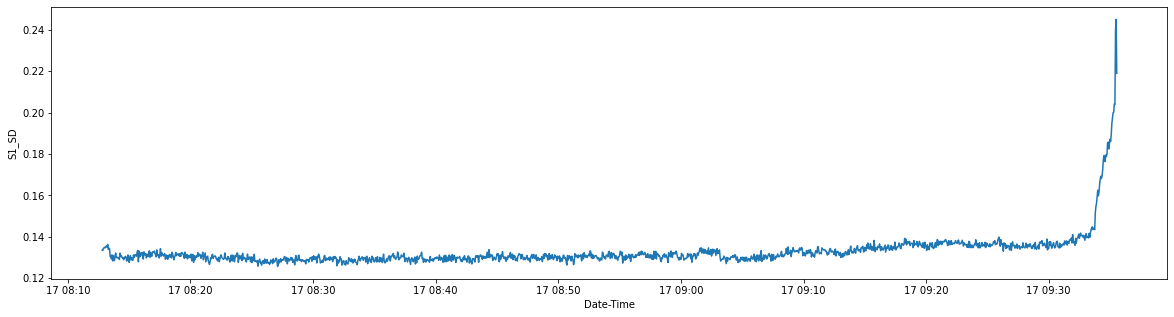

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.xlabel("Date-Time")
plt.ylabel("S1_SD")
plt.plot(vibrationdata.timestamp, vibrationdata.S1_SD)
plt.show()


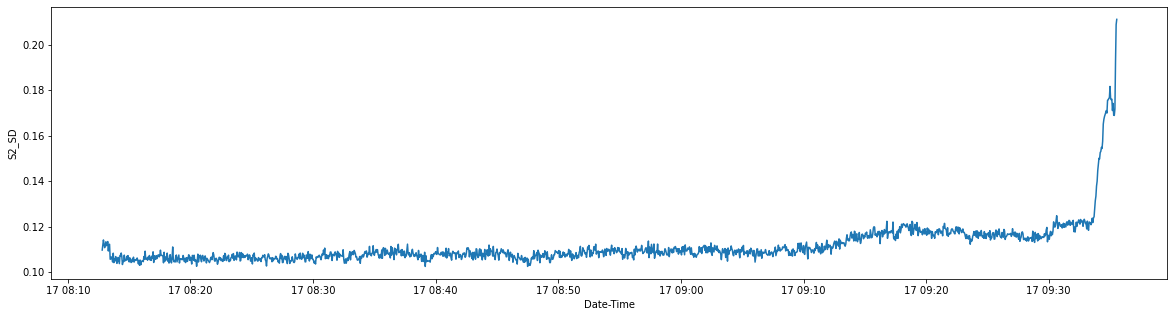

In [7]:
%matplotlib inline

plt.figure(figsize=(20,5))
plt.xlabel("Date-Time")
plt.ylabel("S2_SD")
plt.plot(vibrationdata.timestamp, vibrationdata.S2_SD)
plt.show()

## Oversampling Minority Data

it was understood that the dataset did not contain equal data of the two classes to generate a perfect model for prediction. Hence, the minority data is over-sampled using *SMOTE (Synthetic Minority Oversampling Technique)*.

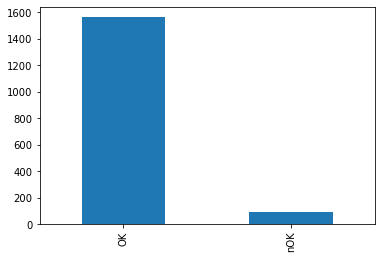

In [8]:
%matplotlib inline

vibrationdata["quality"].value_counts().plot(kind="bar")

plt.show()

In [9]:
%matplotlib inline

x = vibrationdata[["S1_SD", "S2_SD"]]
y = vibrationdata["quality"]

from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

x, y = sm.fit_resample(x, y)

y.value_counts().plot(kind="bar")

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
print(x.shape, y.shape)

## Model Generation

A multi-variate KNN-Classifier model is used for predicition.

In [ ]:
#test train split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn= KNeighborsClassifier(n_neighbors=3)

knn.fit(x_train, y_train)

predictions = knn.predict(x_test)

## Evaluation

To evaluate the model performance, accuracy and confusion matrix socres are calculated.

In [ ]:
%matplotlib inline

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_test, predictions)

cm = confusion_matrix(y_test, predictions)

print("accuracy: ", acc)

plt.figure(figsize=(10,6))

ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['ok', 'nok'])
ax.yaxis.set_ticklabels(['ok', 'nok'])

plt.show()